# Project: Dense Prediction: Monocular Depth Estimation and Semantic Segmentation

<img src='https://i.imgur.com/I2rSgxd.png' width=200> <img src='https://i.imgur.com/1oP2EIg.png' width=200>

# Part 1
## Introduction

- In this part of the project, you are tasked to create a model that **estimates depth from a single input image**. The input is an RGB image and the output is a single channel dense depth map where each pixel is the estimated distance from the 'camera sensor' to an object in the scene in real world units (e.g. in meters). Depth from a single image is a fundemental vision task with many useful applications including scene understanding and reconstruction.

- You are to develop a convolutional neural network (CNN) that formulates the problem as a regression of the depth map from a single RGB image. 

- In this section, we provide all the source code needed for loading and evaluating your model.  You will reuse the model in the next section

- Your task in this section is to modify the script in order to:
    - Define a [UNet](https://arxiv.org/abs/1505.04597) model that takes an RGB image and outputs a single channel depth map. **[25 points]**
    - Define an approprate loss function. **[15 points]**
    - Tune the model to achieve an RMSE of **0.035** or less on the given validation set. **[25 points]**


<hr/>

**Note**: Make sure that your Collab notebook is a GPU instance. Also, the first time you run the training, the instance might crash for exceeding the allocated memory. This is expected behaviour, especially with large batch sizes. Collab will suggest restarting the session and providing instances with larger memory sizes.

**Note**: This project is more open-ended than the previous projects. Multiple solutions can be considered _correct_. As there already exist implementations of various deep networks for this task on the interwebs, **plagiarism will NOT be tolerated**. Your code will be judged for similarity against code available online and other students' code. You are expected to justify every design decision when your project is being evaluated.

**Note**: The networks you will design/implement will be much larger than what you have previously designed. Please bring hardware concerns to the attention of the [TA](mailto:wamiq.para@kaust.edu.sa). You will need to begin early to test out new ideas/hyperparameters and training will take much longer. Best of luck!

<hr/>

## Downloading Data
Run the following cell to download the dataset and extract the zip archive.

If you are not running a Linux/Mac machine. Please download the following zip file manually and extract it in the same directory as the notebook.

In [1]:
#! wget -nc https://densedepth2019.s3.amazonaws.com/UnrealData256.zip
#! unzip -nq UnrealData256.zip

## Hyperparameters

You are supposed to change the batch_size and learning_rate from their default value.

In [5]:
import os
import gc
import time
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

epochs = 10
batch_size = 8
learning_rate = 0.001
workers = 1 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

In [6]:
%cd Depth_Estimation/

[Errno 2] No such file or directory: 'Depth_Estimation/'
/ibex/scratch/longy/workspace/cs323/Project_Dense_Prediction


In [7]:
torch.cuda.device_count()

4

## Data Loader (no tasks required)

In [9]:
if __name__ == '__main__':
    from loaders2 import prep_loaders
    train_loader, valid_loader = prep_loaders('UnrealData256', batch_size=batch_size, workers=workers)

IndentationError: unexpected indent (loaders2.py, line 83)

## Sanity check 

In [1]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
print(sample['image'].shape, sample['depth'].shape)
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])

Populating the interactive namespace from numpy and matplotlib


NameError: name 'train_loader' is not defined

## Model [25 points]

Define your model here. The current model is going to perform very poorly on the task. 
But it will be fast. You are welcome to run it.

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.A = nn.Conv2d(3, 1, kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        return self.A(x)
    
def create_model_gpu():
    model = Model()
    model = model.cuda()
    model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
    return model

model = create_model_gpu()
print('Ready to train.')

#model.load_state_dict(torch.load('trained_model.pkl'))

Ready to train.


In [5]:
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, down):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        if(down==1):
            self.conv = Down(in_channels, out_channels,pooling=False)
        else:
            self.conv = Down2(in_channels, out_channels,pooling=False)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.shape[2] - x1.shape[2]
        diffX = x2.shape[3] - x1.shape[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2]) 

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [6]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels,pooling=True):
        super().__init__()
        self.pooling = pooling
        self.maxpool = nn.MaxPool2d(2)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        if(self.pooling):
            return self.maxpool(self.double_conv(x))
        else:
            return self.double_conv(x)


In [7]:
class Down2(nn.Module):
    def __init__(self, in_channels, out_channels,pooling=True):
        super().__init__()
        self.pooling = pooling
        self.maxpool = nn.MaxPool2d(2)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        if(self.pooling):
            return self.maxpool(self.double_conv(x))
        else:
            return self.double_conv(x)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.down1 = Down(3,64,pooling=False)
        self.down2 = Down(64,128,pooling=True)
        self.down3 = Down2(128,256,pooling=True)
        self.down4 = Down2(256,512,pooling=True)
        self.down5 = Down2(512,1024,pooling=True)

        self.up1 = Up(1024,512,down=2)
        self.up2 = Up(512, 256,down=2)
        self.up3 = Up(256, 128,down=2)
        self.up4 = Up(128, 64,down=1)
        self.maxpool = nn.MaxPool2d(2)
        self.conv = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, x):

        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x = self.up1(x5,x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.maxpool(x)
        x = self.conv(x)
        return x

In [11]:
model = Model()
model = model.cuda()
model = nn.DataParallel(model, device_ids=[g for g in gpu_id])

## Loss Function [15 points]

Define a loss function that is suitable for the dense regression task.
Why will the current loss not work? Submit the answer in the notebook.

### The reasons why the current loss not work is because the expection of the y_pred - y should be 0. More data you get, closer to 0. We should let all error be positive. For example, taking absoult or squre. 

### Here I tried three loss function, MAE, RMSE, and RMLSE. The performance of MAE and RMSE are no different in 100 epoch, but the speed of MAE is about 5/7 faster than RMSE. Check LOG/log.12133070 and LOG/log.12134052 for the training log for MAE and RMSE.

### I also Tried RMLSE, but Failed. 

In [10]:
import torch
from math import exp
import torch.nn.functional as F

def loss_fn(pred_y, y):
    ##MAE
    #return torch.mean(torch.abs(y.sub(y_pred)))
    #####RMSE
    return torch.sqrt(torch.mean((pred_y-y)**2))
    ####RMLSE
    #return torch.sqrt(torch.mean((torch.log(pred_y+1)-torch.log(y+1))**2))


## Training + Evaluation [25 points]

Tune the hyperparameters and the architecture to achieve the target RMSE

In [10]:
import warnings
warnings.filterwarnings("ignore")

### Fistly I used the model with just 3 down and 3 up to tune the learning_rate and found that leaning_rate less than 0.05 was good and no difference. However, RMSE could only reached 0.08, which was far away from 0.035. Then I decied to added to 4 down and 4 up net in Model and used learning rate=0.001. 

#### Task1_Model2_RMSE.py: Used Only Double Convolution in Down scaling and epoch=16
#### Task1_Model3_RMSE.py: Used Bout Double Convolution and Triple Convolution in Down scaling and epoch=32

#### Model2 reached RMSE=0.362 (LOG/log.12134090)
#### wheras Model3 reached RMSE=0.270 (LOG/log.12134052 ）

In [ ]:
run_id = 'model_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0


# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH

metrics = RMSE()

for epoch in range(epochs):
    model.train()
    
    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['depth'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        
        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT//50) == 0:
            print('.', end='')
            
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; gc.collect()
    
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['depth'].numpy()
        with torch.no_grad():
            y_pred = model(x).detach().cpu().numpy()

        metrics.add_batch(y_pred, y)
        print('_', end='')
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))
    

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

## Visual Test of the Trained Model (no tasks required)

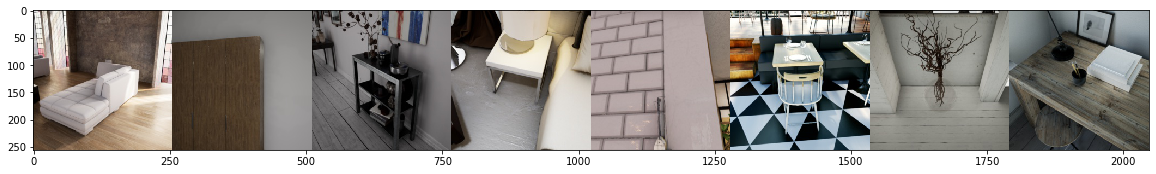

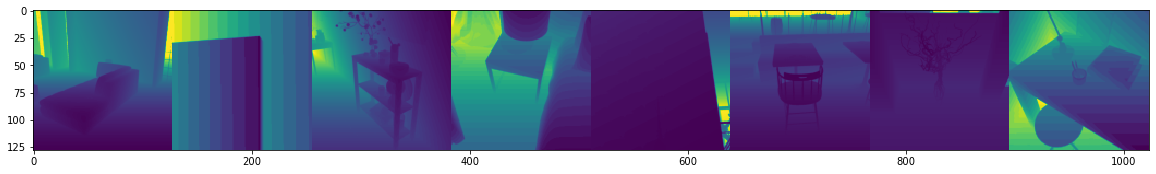

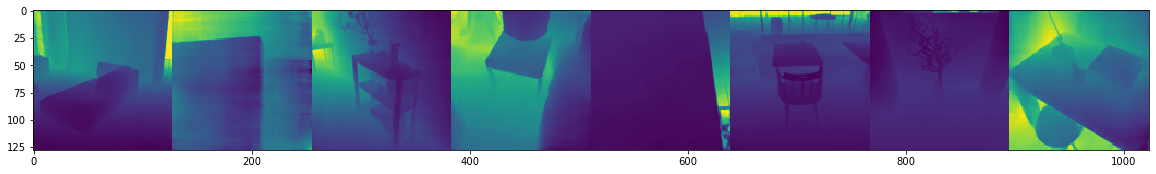

In [12]:
# Load model from disk
model = create_model_gpu()
model.load_state_dict(torch.load('model3_gpu[0, 1, 2, 3]_n100_bs32_lr0.001.pkl'))
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['image'].float().cuda()
y_pred, y = model(x), sample['depth']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])